In [1]:
import numpy as np
import pandas as pd
import gdown
import re
import matplotlib.pyplot as plt

In [2]:
# Подключение колбэков для оптимизации обучения и сохранения результатов
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Разделение данных на выборки
from sklearn.model_selection import train_test_split
from keras import metrics as metr
from keras import utils
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import GlobalMaxPooling1D, Dropout, MaxPooling1D, BatchNormalization, SpatialDropout1D, Conv1D, Flatten, Dense, SimpleRNN, Concatenate, Input, concatenate, LSTM, Embedding, GRU, Bidirectional

In [3]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1XuNrXWd4zvyCO_mjvelEStGENdBQJUI7', None, quiet=True)

'train_2.zip'

In [4]:
!unzip -q "/content/train_2.zip" -d /content

In [5]:
data = pd.read_csv('train_2.csv', sep=',', header=0, index_col=None) # Загружаем базу
data.head(10)

,text,labels
0,"And this year, the number will be over 150,000...","{'science', 'family', 'mobility'}"
1,MR. SPICER: I think the campaign will make dec...,"{'economy', 'languages', 'style'}"
2,You dont have to test every person in the stat...,{'family'}
3,And Dr. Fauci is going to emphasize this about...,"{'science', 'family', 'history'}"
4,SANDERS: Certainly in a number of the conversa...,"{'science', 'news'}"
5,PRESIDENT MACRON: But Im very honored and very...,{'politics'}
6,But we will be meeting at the G20.,"{'science', 'economy'}"
7,And are you worried if thats encouraged?,"{'family', 'style', 'affair'}"
8,"Here, at this memorial, the names of those 40 ...",{'mobility'}
9,We hope we still have hope that the dispute wi...,"{'economy', 'news', 'style'}"


In [6]:
#Берем только 300000 сообщений, больше обучить не получается по нехватке памяти

#Данную проблему можно решить обучением по частям с сохранением промежуточных результатов
df=data[:300_000]

In [7]:
df

,text,labels
0,"And this year, the number will be over 150,000...","{'science', 'family', 'mobility'}"
1,MR. SPICER: I think the campaign will make dec...,"{'economy', 'languages', 'style'}"
2,You dont have to test every person in the stat...,{'family'}
3,And Dr. Fauci is going to emphasize this about...,"{'science', 'family', 'history'}"
4,SANDERS: Certainly in a number of the conversa...,"{'science', 'news'}"
...,...,...
299995,Chand and Fiza had also announced that they w...,"{'business', 'self-driving cars', 'science'}"
299996,I was trying to figure out if you could draw a...,{'mobility'}
299997,Did you at least like Bring it On Fuck,"{'business', 'health'}"
299998,Eurasians have twice the mental illness on ave...,"{'science', 'self-driving cars', 'news'}"


In [8]:
maxWordsCount = 20000 #число слов, которые войдут в словарь частотности
sent_len = 50 #максимальная длина предложения (длина развернутой RNN сети)

In [9]:
df=df.dropna() #выкидываем пустые строки

In [10]:
#Токинизируем текст

#В случае обучения по частям необходимо использовать один токинизатор для всех частей
#Можно подгрузить готовый
token = Tokenizer(num_words=maxWordsCount, filters='0123456789–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff', lower=True, split=' ', char_level=False, oov_token = 'NaN')
token.fit_on_texts(df.text)
items=list(token.word_index.items())

In [12]:
print(items[:50])

[('NaN', 1), ('the', 2), ('to', 3), ('and', 4), ('a', 5), ('of', 6), ('i', 7), ('in', 8), ('that', 9), ('you', 10), ('is', 11), ('for', 12), ('it', 13), ('will', 14), ('be', 15), ('this', 16), ('on', 17), ('we', 18), ('going', 19), ('have', 20), ('with', 21), ('are', 22), ('but', 23), ('not', 24), ('was', 25), ('as', 26), ('were', 27), ('so', 28), ('they', 29), ('at', 30), ('he', 31), ('my', 32), ('if', 33), ('its', 34), ('from', 35), ('president', 36), ('all', 37), ('our', 38), ('do', 39), ('has', 40), ('just', 41), ('your', 42), ('what', 43), ('about', 44), ('by', 45), ('people', 46), ('like', 47), ('me', 48), ('one', 49), ('an', 50)]


In [13]:
#Переводим и индексы текст
text_seq = token.texts_to_sequences(df.text)

In [15]:
type_class = ['work', 'news', 'sports', 'music', 'movies',
'politics', 'phones', 'self-driving_cars',
'family', 'cars', 'climate_change', 'languages',
'business', 'health', 'science', 'style', 'opinion',
'economy', 'history', 'technology', 'affair', 'development', 'mobility']

In [17]:
#Подгатавливаем метки в виде OHE (One Hot Encoding)
#Сначала создадим массив из нулей размерностью количество классов на количество записей
n_class = np.zeros(shape=(len(df), len(type_class)))
n_class.shape

(299999, 23)

In [18]:
#Теперь прогоним в соответствующих классу индексах для каждой строчки заменим 0 на 1 если такой класс существует
patterns = r"['{},]+"

for i, label in enumerate(df.labels):
  label=label.replace('self-driving cars','self-driving_cars')
  label=label.replace('climate change','climate_change')
  for cur_babel in re.sub(patterns, '', label).split():
      n_class[i][type_class.index(cur_babel)]=1

In [19]:
#все предложения длиной <50 дополняем нулями в конце, >50 - обрезаем
X_train = pad_sequences(text_seq, maxlen=sent_len, padding='post', truncating='post')

In [20]:
# 10 Самых часто встречающихся слов заменим на индекс 2 (как не значительные)
X_train = np.where((X_train<10)&(X_train>1), 2, X_train)

In [21]:
print(X_train.shape)
print(n_class.shape)

(299999, 50)
(299999, 23)


In [22]:
n_class[45]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0.])

In [23]:
#Разобьем выборку на обучаемую и проверочную
x_train, x_val, y_train, y_val = train_test_split(np.asarray(X_train),
                                                  n_class,
                                                  test_size=0.10,
                                                  shuffle=True)


In [24]:
Y=[np.argmax(y) for y in n_class]
for i in range (23):
  print(i, Y.count(i))


0 460
1 17095
2 38628
3 1582
4 938
5 12161
6 8505
7 27229
8 12525
9 6674
10 3324
11 16657
12 2765
13 6330
14 63624
15 31813
16 388
17 7661
18 883
19 4274
20 13495
21 7382
22 15606


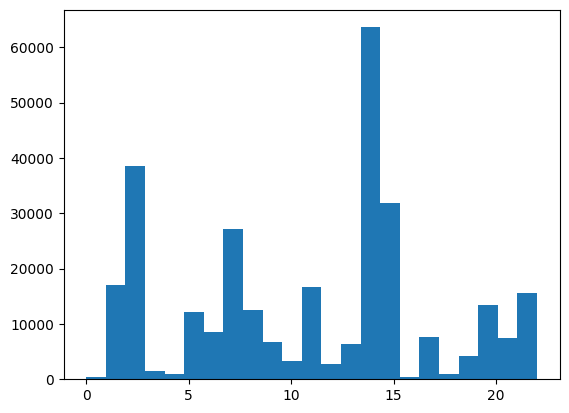

In [25]:
#Выборка не сбалансированна, и этот проблемма
plt.hist(Y, bins=23)
plt.show()

In [26]:
#Создадим сверточную модель
model_2 = Sequential()
model_2.add(Embedding(maxWordsCount, sent_len, input_length=sent_len)) # Формируем векторное пространство слов
model_2.add(SpatialDropout1D(0.3))                                     # "Прореживание" пространства
#model_2.add(Conv1D(128, 4, activation='relu'))                         # сверточный слой
model_2.add(Conv1D(256, 3, activation='relu'))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(128, activation='relu'))                              # полносвязанный слой
model_2.add(Dropout(0.3))
model_2.add(Dense(23, activation='softmax')) #softmax                           # выходной слой

In [27]:
checkpoint = ModelCheckpoint("best_text_class.h5", monitor='val_loss', save_best_only=True)

model_2.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=1e-4), metrics=['accuracy','AUC'])

In [28]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 48, 256)           38656     
                                                                 
 global_max_pooling1d (Glob  (None, 256)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0

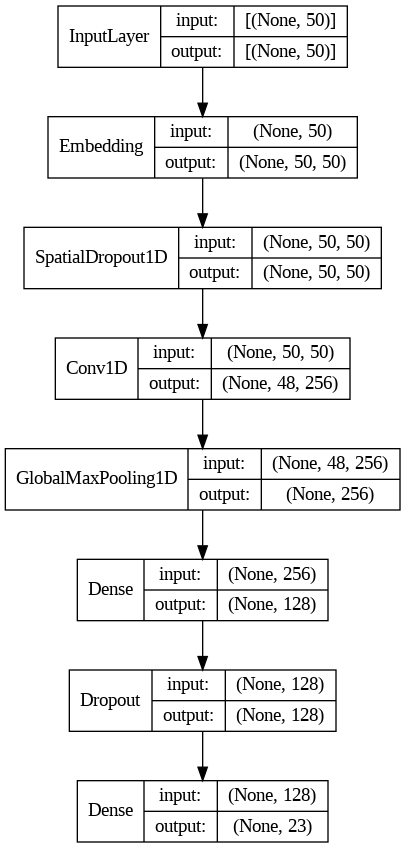

In [25]:
utils.plot_model(model_2, show_layer_names=False, show_shapes=True)

In [50]:
# Проведем обучение на 20 эпохах
history = model_2.fit(x_train,
                      y_train,
                      batch_size=128,
                      epochs=20,
                      callbacks=[checkpoint],
                      validation_data = (x_val, y_val))

Epoch 1/20
2110/2110 [==============================] - 19s 9ms/step - loss: 0.2007 - accuracy: 0.2856 - auc: 0.8627 - val_loss: 0.1961 - val_accuracy: 0.2948 - val_auc: 0.8706
Epoch 2/20
2110/2110 [==============================] - 13s 6ms/step - loss: 0.1994 - accuracy: 0.2912 - auc: 0.8646 - val_loss: 0.1948 - val_accuracy: 0.3010 - val_auc: 0.8724
Epoch 3/20
2110/2110 [==============================] - 19s 9ms/step - loss: 0.1982 - accuracy: 0.2974 - auc: 0.8663 - val_loss: 0.1935 - val_accuracy: 0.3085 - val_auc: 0.8742
Epoch 4/20
2110/2110 [==============================] - 14s 7ms/step - loss: 0.1969 - accuracy: 0.3036 - auc: 0.8679 - val_loss: 0.1923 - val_accuracy: 0.3165 - val_auc: 0.8760
Epoch 5/20
2110/2110 [==============================] - 17s 8ms/step - loss: 0.1957 - accuracy: 0.3086 - auc: 0.8695 - val_loss: 0.1911 - val_accuracy: 0.3194 - val_auc: 0.8776
Epoch 6/20
2110/2110 [==============================] - 14s 7ms/step - loss: 0.1946 - accuracy: 0.3130 - auc: 0.870

## Далее работа с тестовыми данными

In [30]:
gdown.download('https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1KoMxSOA4C9j1ZWYYQsr_4TUwccFk4G7V', None, quiet=True)

'test.zip'

In [31]:
!unzip -q "/content/test.zip" -d /content

In [32]:
df_test=pd.read_csv('test.csv', sep=',', header=0, index_col=None) # Загружаем базу

In [33]:
df_test

,text
0,noraemingi CaratExolAtiny ATEEZofficial YES QU...
1,Not to mention I take advantage of Steam Cloud...
2,MlindoRSA Dropping tomorrow Yekela NewMusic f...
3,Singh's supporters refused to hand over the b...
4,"Founded in 1981, Bafna Pharmaceutical, which ..."
...,...
3729985,CBSins69 love it n follow me nNaughtySinsatio...
3729986,SOFTJEETH this is still my peak jisung nothin...
3729987,There's interest from developers in Windows P...
3729988,***Seriously it seems like you have played a l...


In [34]:
#df_test=df_test.astype(str)
df_test=df_test.fillna('Empty')

In [35]:
test_seq = token.texts_to_sequences(df_test.text)

In [36]:
# почему-то в тесте не хватает строки
print(len(test_seq))

3729990


In [37]:
#Проводим те-же манипутяции, что и с данными для обучения
x_test = pad_sequences(test_seq, maxlen=sent_len, padding='post', truncating='post')

In [38]:
x_test = np.where((x_test<10)&(x_test>1), 2, x_test)

In [39]:
x_test.shape

(3729990, 50)

In [62]:
# получаем предсказание
currPred=model_2.predict(x_test[:])

116563/116563 [==============================] - 271s 2ms/step


In [41]:
type_rez_class = ['work', 'news', 'sports', 'music', 'movies',
'politics', 'phones', 'self-driving cars',
'family', 'cars', 'climate change', 'languages',
'business', 'health', 'science', 'style', 'opinion',
'economy', 'history', 'technology', 'affair', 'development', 'mobility']

In [64]:
# Преобразуем данные предсказания в классы
rez=[]
for n in range(len(x_test)):
  p=[]
  for i, el in enumerate(currPred[n]):
    if el>0.2:
      p.append(type_rez_class[i])
  if type_rez_class[np.argmax(currPred[n])] not in p:
    p.append(type_rez_class[np.argmax(currPred[n])])
  rez.append(str(p).replace('[','{').replace(']','}'))

In [66]:
df_rez = pd.DataFrame(rez, columns = ['labels'])

In [67]:
df_rez.to_csv ('task2_rez2.csv', index= True)